###SECTION 1- BASELINE MODEL


In [4]:
import re
import numpy as np

from collections import Counter, defaultdict

# Load words
with open("corpus.txt") as f:
    words = [w.strip().lower() for w in f.readlines() if w.strip().isalpha()]

print(f"Loaded {len(words)} words.")
print("Sample words:", words[:10])


Loaded 49979 words.
Sample words: ['suburbanize', 'asmack', 'hypotypic', 'promoderationist', 'consonantly', 'philatelically', 'cacomelia', 'thicklips', 'luciferase', 'cinematography']


In [5]:
START, END = "^", "$"
transitions = defaultdict(Counter)
letter_counts = Counter()

for word in words:
    word = START + word + END
    for a, b in zip(word, word[1:]):
        transitions[a][b] += 1

# Normalize into probabilities
transition_probs = {
    a: {b: count / sum(nexts.values()) for b, count in nexts.items()}
    for a, nexts in transitions.items()
}

 #Add global letter frequencies for fallback (helps baseline guessing)
total_letters = sum(letter_counts.values())
global_letter_probs = {c: letter_counts[c] / total_letters for c in letter_counts}

print("Example transitions from 't':", transition_probs.get('t', {}))
print("Top 10 most frequent letters:", sorted(global_letter_probs.items(), key=lambda x: x[1], reverse=True)[:10])



Example transitions from 't': {'y': 0.035568947842564695, 'i': 0.20598925165418905, '$': 0.09884750396073437, 'l': 0.014631418719517878, 'e': 0.19070547668603025, 'h': 0.07877978316920879, 'o': 0.09872324562765991, 'a': 0.09505762480196328, 'u': 0.02963561243825914, 's': 0.00512565623932155, 'r': 0.09257245814047405, 'z': 0.0014600354136249261, 'c': 0.007144854151781553, 't': 0.022304370786865896, 'w': 0.006243981236991706, 'f': 0.0036966854089652387, 'n': 0.0031375229101301607, 'm': 0.003634556242428008, 'j': 0.00043490416576061634, 'p': 0.0014600354136249261, 'd': 0.0007455499984467709, 'v': 0.0005902270821036936, 'b': 0.0018017458295796962, 'k': 0.0004970333322978472, 'g': 0.000963002081327079, 'q': 0.00015532291634307727, 'x': 9.319374980584636e-05}
Top 10 most frequent letters: []


In [6]:
max_len = max(len(w) for w in words)
positional_counts = [Counter() for _ in range(max_len)]

for word in words:
    for i, c in enumerate(word):
        positional_counts[i][c] += 1

# Normalize
positional_probs = []
for counts in positional_counts:
    total = sum(counts.values())
    positional_probs.append({c: n / total for c, n in counts.items()})

print("Position 0 (first letter) top frequencies:",
      sorted(positional_probs[0].items(), key=lambda x: x[1], reverse=True)[:10])


Position 0 (first letter) top frequencies: [('p', 0.10400368154624942), ('s', 0.10372356389683667), ('c', 0.08263470657676224), ('a', 0.07159006782848797), ('u', 0.0680285720002401), ('t', 0.05404269793313191), ('m', 0.053302387002541064), ('b', 0.046799655855459296), ('d', 0.04649952980251706), ('r', 0.04103723563896837)]


In [7]:
import string

def hmm_like_letter_probs(masked_word, guessed_letters):
    """
    Given a masked word like '_a__e' and guessed letters {'a','e'},
    return a dict of letter probabilities for the next guess.
    """
    alphabet = string.ascii_lowercase
    probs = {c: 0.0 for c in alphabet}

    # Base probabilities from positional likelihoods
    for i, ch in enumerate(masked_word):
        if ch == "_":
            if i < len(positional_probs):
                for c, p in positional_probs[i].items():
                    if c not in guessed_letters:
                        probs[c] += p

    # Add smoothing from transition likelihoods (for neighboring revealed letters)
    for i, ch in enumerate(masked_word):
        if ch != "_":
            if ch in transition_probs:
                for next_c, p in transition_probs[ch].items():
                    if next_c not in guessed_letters and next_c.isalpha():
                        probs[next_c] += 0.2 * p  # weighted factor

    # Normalize
    total = sum(probs.values())
    if total > 0:
        for c in probs:
            probs[c] /= total
    return probs


In [8]:
masked = "_a__e"
guessed = {'a', 'e'}
probs = hmm_like_letter_probs(masked, guessed)

# Sort top predictions
sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 predicted letters for", masked)
for letter, p in sorted_probs[:10]:
    print(f"{letter}: {p:.4f}")



Top 10 predicted letters for _a__e
r: 0.0961
t: 0.0859
s: 0.0821
n: 0.0734
c: 0.0719
p: 0.0694
i: 0.0661
l: 0.0640
o: 0.0628
u: 0.0507


In [9]:
def next_best_guess(masked_word, guessed_letters):
    probs = hmm_like_letter_probs(masked_word, guessed_letters)
    return max(probs, key=probs.get)


In [10]:
masked = "_a__e"
guessed = {'a', 'e'}
print("Next best guess (Baseline):", next_best_guess(masked, guessed))


Next best guess (Baseline): r


multi hmm- training


In [12]:
import numpy as np
import pickle
from collections import defaultdict, Counter

In [13]:
# Load the given corpus
with open('corpus.txt', 'r') as f:
    corpus = [w.strip().lower() for w in f.readlines() if w.strip().isalpha()]

print(f"Total words in corpus: {len(corpus)}")

# Split corpus by word length
short_words = [w for w in corpus if 1 <= len(w) <= 4]
medium_words = [w for w in corpus if 5 <= len(w) <= 7]
long_words = [w for w in corpus if 8 <= len(w) <= 10]
very_long_words = [w for w in corpus if len(w) >= 11]

print(f"Short: {len(short_words)}, Medium: {len(medium_words)}, Long: {len(long_words)}, Very Long: {len(very_long_words)}")


Total words in corpus: 49979
Short: 1687, Medium: 11206, Long: 19600, Very Long: 17486


In [14]:
def build_transition_probs(words):
    transitions = np.zeros((26, 26))  # a-z
    for w in words:
        for a, b in zip(w[:-1], w[1:]):
            transitions[ord(a)-97, ord(b)-97] += 1
    # normalize rows
    transitions = transitions / np.maximum(transitions.sum(axis=1, keepdims=True), 1)
    return transitions

def build_position_probs(words):
    # dynamically find the longest word in this set
    max_len = max(len(w) for w in words) if words else 1
    position_counts = np.ones((max_len, 26))

    for w in words:
        for i, ch in enumerate(w):
            position_counts[i, ord(ch)-97] += 1

    # normalize by position
    position_counts = position_counts / np.maximum(position_counts.sum(axis=1, keepdims=True), 1)
    return position_counts

def train_custom_hmm(words):
    hmm = {
        "transition": build_transition_probs(words),
        "position": build_position_probs(words)
    }
    hmm["max_len"] = hmm["position"].shape[0]  # save max length info
    return hmm


In [15]:
short_hmm = train_custom_hmm(short_words)
medium_hmm = train_custom_hmm(medium_words)
long_hmm = train_custom_hmm(long_words)
very_long_hmm = train_custom_hmm(very_long_words)


In [16]:
pickle.dump(short_hmm, open("short_hmm1.pkl", "wb"))
pickle.dump(medium_hmm, open("medium_hmm1.pkl", "wb"))
pickle.dump(long_hmm, open("long_hmm1.pkl", "wb"))
pickle.dump(very_long_hmm, open("very_long_hmm1.pkl", "wb"))

print("✅ All 4 HMMs saved successfully!")

✅ All 4 HMMs saved successfully!


In [17]:
for name in ["short_hmm1", "medium_hmm1", "long_hmm1", "very_long_hmm1"]:
    model = pickle.load(open(f"{name}.pkl", "rb"))
    print(f"{name}: transition shape {model['transition'].shape}, position shape {model['position'].shape}")

short_hmm1: transition shape (26, 26), position shape (4, 26)
medium_hmm1: transition shape (26, 26), position shape (7, 26)
long_hmm1: transition shape (26, 26), position shape (10, 26)
very_long_hmm1: transition shape (26, 26), position shape (24, 26)


###SECTION 2- MULTI-HMM INTEGRATION INTO BASELINE

In [18]:
import pickle

short_hmm = pickle.load(open("short_hmm1.pkl", "rb"))
medium_hmm = pickle.load(open("medium_hmm1.pkl", "rb"))
long_hmm = pickle.load(open("long_hmm1.pkl", "rb"))
very_long_hmm = pickle.load(open("very_long_hmm1.pkl", "rb"))


print("Loaded 4 trained HMM models.")


Loaded 4 trained HMM models.


In [19]:
def select_hmm(word_pattern):
    n = len(word_pattern)
    if n <= 4:
        return short_hmm
    elif n <= 7:
        return medium_hmm
    elif n <= 10:
        return long_hmm
    else:
        return very_long_hmm


In [20]:
def predict_next_letters(pattern, guessed):
    hmm = select_hmm(pattern)
    trans = hmm["transition"]
    pos = hmm["position"]
    n = len(pattern)

    probs = np.zeros(26)

    # 1. Use positional probs for BLANK positions only
    for i, ch in enumerate(pattern):
        if ch == "_" and i < len(pos):
            probs += pos[i, :]

    # 2. Add transition information from revealed letters
    for i, ch in enumerate(pattern):
        if ch != "_":
            idx = ord(ch) - 97
            # Check neighbors
            if i > 0 and pattern[i-1] == "_":  # blank before
                probs += 0.5 * trans[idx, :]
            if i < n-1 and pattern[i+1] == "_":  # blank after
                probs += 0.5 * trans[idx, :]

    # 3. Zero out already guessed letters
    for g in guessed:
        probs[ord(g) - 97] = 0

    # 4. Normalize
    total = np.sum(probs)
    if total > 0:
        probs /= total
    else:
        # Fallback to uniform over unguessed
        probs = np.ones(26)
        for g in guessed:
            probs[ord(g) - 97] = 0
        probs /= np.sum(probs)

    # Return ranked
    ranked = sorted(
        [(chr(i+97), p) for i, p in enumerate(probs)],
        key=lambda x: x[1],
        reverse=True
    )
    return ranked[:10]

In [21]:
for pat in ["_a__e", "_____", "__i__n_", "________"]:
    preds = predict_next_letters(pat, guessed=[])
    print(f"\nPattern: {pat}")
    for letter, prob in preds:
        print(f"{letter}: {prob:.4f}")



Pattern: _a__e
r: 0.0992
n: 0.0794
l: 0.0741
t: 0.0712
s: 0.0692
a: 0.0634
c: 0.0511
i: 0.0484
e: 0.0471
m: 0.0447

Pattern: _____
a: 0.1048
e: 0.0907
i: 0.0796
o: 0.0718
r: 0.0667
l: 0.0576
t: 0.0561
n: 0.0546
s: 0.0530
u: 0.0491

Pattern: __i__n_
e: 0.1106
a: 0.0968
n: 0.0734
t: 0.0638
i: 0.0638
o: 0.0591
s: 0.0590
r: 0.0540
l: 0.0531
c: 0.0479

Pattern: ________
e: 0.0989
i: 0.0935
a: 0.0908
o: 0.0773
r: 0.0728
n: 0.0670
t: 0.0656
l: 0.0573
s: 0.0550
c: 0.0428


In [22]:
masked = "_a__e"
guessed = {'a', 'e'}

baseline_guess = next_best_guess(masked, guessed)
integrated_guess = predict_next_letters(masked, guessed)[0][0]

print(f"\nBaseline guess: {baseline_guess}")
print(f"HMM-integrated guess: {integrated_guess}")



Baseline guess: r
HMM-integrated guess: r


###to test


In [23]:
import random

def play_hangman(agent_func, word, max_lives=6):
    masked = ["_"] * len(word)
    guessed = set()
    lives = max_lives
    wrong = 0
    repeated = 0

    while lives > 0 and "_" in masked:
        guess = agent_func("".join(masked), guessed)
        if guess in guessed:
            repeated += 1
            lives -= 1
            continue
        guessed.add(guess)

        if guess in word:
            for i, ch in enumerate(word):
                if ch == guess:
                    masked[i] = guess
        else:
            lives -= 1
            wrong += 1

    success = "_" not in masked
    return {"success": success, "wrong": wrong, "repeated": repeated}


def evaluate_agents(agent_func, word_list, max_lives=6):
    results = {"total": 0, "success": 0, "total_wrong": 0, "total_repeated": 0}
    for word in word_list:
        res = play_hangman(agent_func, word, max_lives)
        results["total"] += 1
        results["total_wrong"] += res["wrong"]
        results["total_repeated"] += res["repeated"]
        if res["success"]:
            results["success"] += 1
    results["success_rate"] = results["success"] / results["total"]
    return results


In [24]:
# Baseline agent
def baseline_agent(masked, guessed):
    return next_best_guess(masked, guessed)

# Integrated agent
def integrated_agent(masked, guessed):
    preds = predict_next_letters(masked, guessed)
    return preds[0][0] if preds else random.choice("abcdefghijklmnopqrstuvwxyz")


In [25]:
with open("test.txt") as f:
    test_words = [w.strip().lower() for w in f.readlines() if w.strip().isalpha()]

print(f"Loaded {len(test_words)} test words.")
print("Sample test words:", test_words[:10])


Loaded 2000 test words.
Sample test words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


In [26]:
res_baseline = evaluate_agents(baseline_agent, test_words, max_lives=6)
res_integrated = evaluate_agents(integrated_agent, test_words, max_lives=6)


## part 2 - HMM with RL.

In [27]:
import numpy as np
import random
from collections import defaultdict, Counter
import pickle
import matplotlib.pyplot as plt

In [28]:
# Load training corpus
with open("corpus.txt") as f:
    words = [w.strip().lower() for w in f.readlines() if w.strip().isalpha()]

# Load test set
with open("test.txt") as f:
    test_words = [w.strip().lower() for w in f.readlines() if w.strip().isalpha()]

print(f"Training corpus: {len(words)} words")
print(f"Test set: {len(test_words)} words")

Training corpus: 49979 words
Test set: 2000 words


In [29]:
# Load your pre-trained HMMs
short_hmm = pickle.load(open("short_hmm1.pkl", "rb"))
medium_hmm = pickle.load(open("medium_hmm1.pkl", "rb"))
long_hmm = pickle.load(open("long_hmm1.pkl", "rb"))
very_long_hmm = pickle.load(open("very_long_hmm1.pkl", "rb"))

def select_hmm(word_pattern):
    n = len(word_pattern)
    if n <= 4:
        return short_hmm
    elif n <= 7:
        return medium_hmm
    elif n <= 10:
        return long_hmm
    else:
        return very_long_hmm

print("HMMs loaded successfully")

HMMs loaded successfully


In [30]:
def predict_next_letters_hmm(pattern, guessed):
    """Your improved HMM predictor from before"""
    hmm = select_hmm(pattern)
    trans = hmm["transition"]
    pos = hmm["position"]
    n = len(pattern)

    probs = np.zeros(26)

    # Use positional probs for BLANK positions only
    for i, ch in enumerate(pattern):
        if ch == "_" and i < len(pos):
            probs += pos[i, :]

    # Add transition information from revealed letters
    for i, ch in enumerate(pattern):
        if ch != "_":
            idx = ord(ch) - 97
            # Check neighbors
            if i > 0 and pattern[i-1] == "_":
                probs += 0.5 * trans[idx, :]
            if i < n-1 and pattern[i+1] == "_":
                probs += 0.5 * trans[idx, :]

    # Zero out guessed letters
    for g in guessed:
        probs[ord(g) - 97] = 0

    # Normalize
    total = np.sum(probs)
    if total > 0:
        probs /= total
    else:
        probs = np.ones(26)
        for g in guessed:
            probs[ord(g) - 97] = 0
        probs /= np.sum(probs)

    # Return ranked
    ranked = sorted(
        [(chr(i+97), p) for i, p in enumerate(probs)],
        key=lambda x: x[1],
        reverse=True
    )
    return ranked

In [31]:
class HangmanEnv:
    def __init__(self, word_list, max_lives=6):
        self.word_list = word_list
        self.max_lives = max_lives
        self.reset()

    def reset(self):
        """Start a new game"""
        self.word = random.choice(self.word_list)
        self.masked = ['_'] * len(self.word)
        self.guessed = set()
        self.lives = self.max_lives
        self.done = False
        return self._get_state()

    def step(self, action):
        """Take action (guess a letter), return (state, reward, done)"""
        letter = chr(action + 97)  # action is 0-25, convert to 'a'-'z'

        # Repeated guess penalty
        if letter in self.guessed:
            reward = -10
            self.lives -= 1
            self.done = self.lives <= 0
            return self._get_state(), reward, self.done

        self.guessed.add(letter)

        # Check if letter is in word
        if letter in self.word:
            # Correct guess
            count = 0
            for i, ch in enumerate(self.word):
                if ch == letter:
                    self.masked[i] = letter
                    count += 1

            reward = count * 2  # Reward proportional to letters revealed

            # Win bonus
            if '_' not in self.masked:
                reward += 50
                self.done = True
        else:
            # Wrong guess
            self.lives -= 1
            reward = -5

            if self.lives <= 0:
                reward = -20  # Loss penalty
                self.done = True

        return self._get_state(), reward, self.done

    def _get_state(self):
        """Return state representation"""
        return (''.join(self.masked), frozenset(self.guessed), self.lives)

    def get_valid_actions(self):
        """Return list of valid action indices (unguessed letters)"""
        return [i for i in range(26) if chr(i + 97) not in self.guessed]

# Test environment
env = HangmanEnv(words[:100])
state = env.reset()
print(f"Initial state: {state}")
print(f"Actual word: {env.word}")

Initial state: ('__________', frozenset(), 6)
Actual word: fusionless


In [32]:
class ProperHMMGuidedQLearning:
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.9995, epsilon_min=0.01):
        self.Q = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def _get_q_values(self, state):
        if state not in self.Q:
            self.Q[state] = np.zeros(26)
        return self.Q[state]

    def _get_hmm_probs(self, masked, guessed):
        """Get HMM probability distribution"""
        hmm_preds = predict_next_letters_hmm(masked, list(guessed))
        probs = np.zeros(26)
        for letter, prob in hmm_preds:
            probs[ord(letter) - 97] = prob
        return probs

    def _create_state(self, masked, guessed, lives):
        """
        Create state representation following the guidance:
        - Masked word pattern (simplified)
        - Guessed letters
        - Lives remaining
        - TOP-K HMM probabilities (discretized for state space)
        """
        hmm_probs = self._get_hmm_probs(masked, guessed)

        # Get top 3 letters suggested by HMM (discretized)
        top_indices = np.argsort(hmm_probs)[-3:][::-1]
        top_letters = tuple(chr(i + 97) for i in top_indices)

        # Simplified pattern (length, blanks, lives)
        pattern_info = (len(masked), masked.count('_'), lives)

        # State includes HMM guidance
        return (pattern_info, frozenset(guessed), top_letters)

    def get_action(self, masked, guessed, lives, valid_actions):
        """
        Choose action using epsilon-greedy with HMM guidance
        """
        state = self._create_state(masked, guessed, lives)
        hmm_probs = self._get_hmm_probs(masked, guessed)

        if random.random() < self.epsilon:
            # Exploration: HMM-weighted random (smarter exploration)
            valid_probs = [hmm_probs[a] for a in valid_actions]
            total = sum(valid_probs)
            if total > 0:
                valid_probs = [p/total for p in valid_probs]
                return np.random.choice(valid_actions, p=valid_probs)
            else:
                return random.choice(valid_actions)
        else:
            # Exploitation: Combine Q-values with HMM
            q_values = self._get_q_values(state)

            # The RL agent LEARNS when to trust HMM vs override it
            best_action = None
            best_score = float('-inf')

            for action in valid_actions:
                # Combine learned Q-value with HMM suggestion
                score = q_values[action] + hmm_probs[action]
                if score > best_score:
                    best_score = score
                    best_action = action

            return best_action

    def update(self, old_masked, old_guessed, old_lives, action, reward,
               new_masked, new_guessed, new_lives, next_valid_actions, done):
        """Q-learning update"""
        state = self._create_state(old_masked, old_guessed, old_lives)
        current_q = self._get_q_values(state)[action]

        if done:
            target = reward
        else:
            next_state = self._create_state(new_masked, new_guessed, new_lives)
            if next_valid_actions:
                next_q_values = self._get_q_values(next_state)
                max_next_q = max(next_q_values[a] for a in next_valid_actions)
            else:
                max_next_q = 0
            target = reward + self.gamma * max_next_q

        self._get_q_values(state)[action] = current_q + self.alpha * (target - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

print("Proper HMM-Guided Q-Learning Agent (following assignment guidance)")

Proper HMM-Guided Q-Learning Agent (following assignment guidance)


In [33]:
def train_proper_agent(word_list, episodes=30000, max_lives=6):
    env = HangmanEnv(word_list, max_lives)
    agent = ProperHMMGuidedQLearning()

    episode_rewards = []
    episode_wins = []
    episode_wrong_guesses = []

    for ep in range(episodes):
        state = env.reset()
        masked, guessed, lives = state
        total_reward = 0
        wrong_guesses = 0

        while not env.done:
            valid_actions = env.get_valid_actions()
            action = agent.get_action(masked, guessed, lives, valid_actions)

            old_masked, old_guessed, old_lives = masked, guessed, lives

            next_state, reward, done = env.step(action)
            masked, guessed, lives = next_state
            next_valid_actions = env.get_valid_actions()

            if reward < 0 and reward != -20:
                wrong_guesses += 1

            agent.update(old_masked, old_guessed, old_lives, action, reward,
                        masked, guessed, lives, next_valid_actions, done)

            total_reward += reward

        agent.decay_epsilon()

        episode_rewards.append(total_reward)
        episode_wins.append('_' not in env.masked)
        episode_wrong_guesses.append(wrong_guesses)

        if (ep + 1) % 2000 == 0:
            recent_wins = sum(episode_wins[-2000:])
            recent_reward = np.mean(episode_rewards[-2000:])
            recent_wrong = np.mean(episode_wrong_guesses[-2000:])
            print(f"Episode {ep+1}/{episodes} | Wins: {recent_wins}/2000 ({recent_wins/20:.1f}%) | "
                  f"Avg Reward: {recent_reward:.2f} | Avg Wrong: {recent_wrong:.2f} | Epsilon: {agent.epsilon:.3f}")

    return agent, episode_rewards, episode_wins, episode_wrong_guesses

In [34]:
# Train the agent
print("=== Training HMM-Guided RL Agent ===\n")
agent, rewards, wins, wrong_guesses = train_proper_agent(words, episodes=30000, max_lives=6)

print("\n✅ Training complete!")
print(f"Final epsilon: {agent.epsilon:.4f}")
print(f"Q-table size: {len(agent.Q)} states")

=== Training HMM-Guided RL Agent ===

Episode 2000/30000 | Wins: 251/2000 (12.6%) | Avg Reward: -22.38 | Avg Wrong: 4.90 | Epsilon: 0.368
Episode 4000/30000 | Wins: 340/2000 (17.0%) | Avg Reward: -18.14 | Avg Wrong: 4.84 | Epsilon: 0.135
Episode 6000/30000 | Wins: 407/2000 (20.4%) | Avg Reward: -14.65 | Avg Wrong: 4.77 | Epsilon: 0.050
Episode 8000/30000 | Wins: 459/2000 (22.9%) | Avg Reward: -12.60 | Avg Wrong: 4.74 | Epsilon: 0.018
Episode 10000/30000 | Wins: 497/2000 (24.9%) | Avg Reward: -11.03 | Avg Wrong: 4.72 | Epsilon: 0.010
Episode 12000/30000 | Wins: 456/2000 (22.8%) | Avg Reward: -12.42 | Avg Wrong: 4.71 | Epsilon: 0.010
Episode 14000/30000 | Wins: 473/2000 (23.6%) | Avg Reward: -11.92 | Avg Wrong: 4.72 | Epsilon: 0.010
Episode 16000/30000 | Wins: 478/2000 (23.9%) | Avg Reward: -11.70 | Avg Wrong: 4.73 | Epsilon: 0.010
Episode 18000/30000 | Wins: 427/2000 (21.4%) | Avg Reward: -13.71 | Avg Wrong: 4.78 | Epsilon: 0.010
Episode 20000/30000 | Wins: 468/2000 (23.4%) | Avg Reward

In [35]:
# Save trained agent
with open("hmm_rl_agent.pkl", "wb") as f:
    pickle.dump(agent, f)

print("HMM-Guided RL Agent saved to hmm_rl_agent_guideline.pkl")

HMM-Guided RL Agent saved to hmm_rl_agent_guideline.pkl


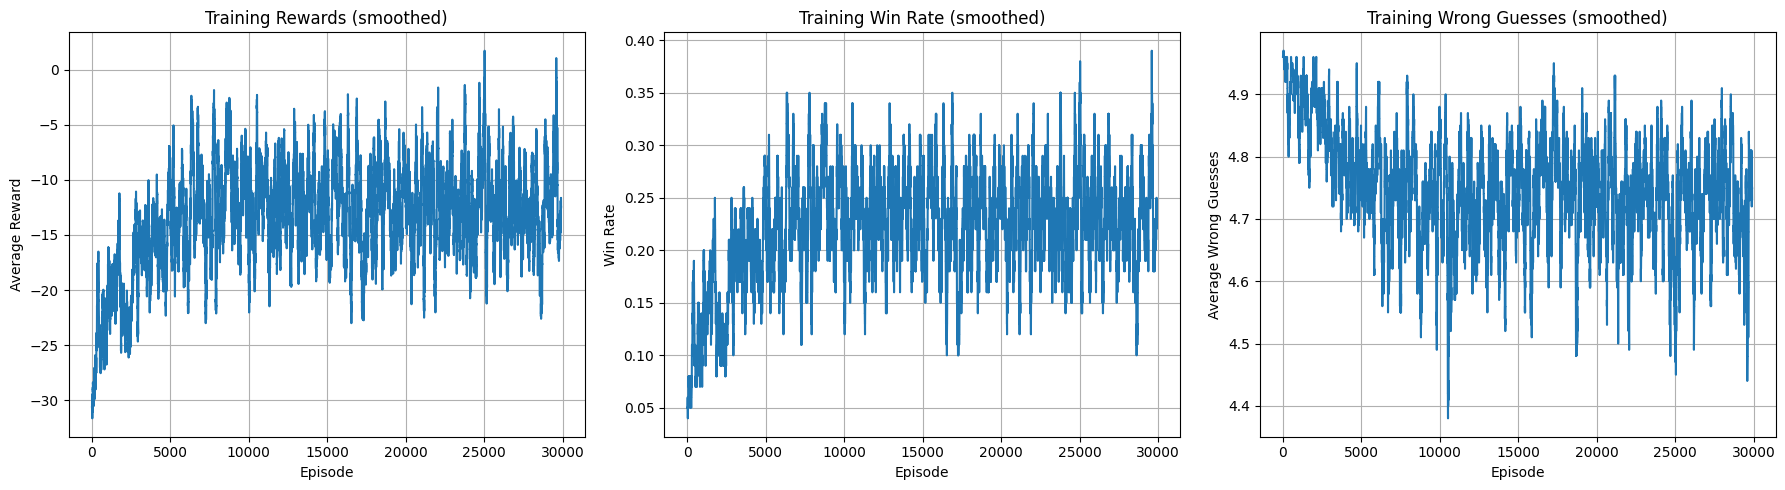

In [36]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Moving average window
window = 100

# Rewards
rewards_smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
axes[0].plot(rewards_smooth)
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Average Reward')
axes[0].set_title('Training Rewards (smoothed)')
axes[0].grid(True)

# Win rate
wins_binary = [1 if w else 0 for w in wins]
win_rate_smooth = np.convolve(wins_binary, np.ones(window)/window, mode='valid')
axes[1].plot(win_rate_smooth)
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Win Rate')
axes[1].set_title('Training Win Rate (smoothed)')
axes[1].grid(True)

# Wrong guesses
wrong_smooth = np.convolve(wrong_guesses, np.ones(window)/window, mode='valid')
axes[2].plot(wrong_smooth)
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Average Wrong Guesses')
axes[2].set_title('Training Wrong Guesses (smoothed)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [37]:
def evaluate_hmm_guided_agent(agent, test_words, max_lives=6, verbose=True):
    """Evaluate HMM-guided agent on test set"""
    results = {"total": 0, "success": 0, "total_wrong": 0, "total_repeated": 0}

    for idx, word in enumerate(test_words):
        env = HangmanEnv([word], max_lives)
        state = env.reset()

        wrong = 0
        repeated = 0

        while not env.done:
            valid_actions = env.get_valid_actions()

            # Greedy: use HMM + learned Q-values
            masked, guessed, lives = state
            hmm_probs = agent._get_hmm_probs(masked, guessed)
            q_values = agent._get_q_values(state)

            combined_scores = {}
            for action in valid_actions:
                combined_scores[action] = hmm_probs[action] + 0.3 * q_values[action]

            if combined_scores:
                action = max(combined_scores, key=combined_scores.get)
            else:
                action = random.choice(range(26))

            next_state, reward, done = env.step(action)

            if reward == -10:
                repeated += 1
            elif reward < 0 and reward != -20:
                wrong += 1

            state = next_state

        results["total"] += 1
        if '_' not in env.masked:
            results["success"] += 1
        results["total_wrong"] += wrong
        results["total_repeated"] += repeated

        if verbose and (idx + 1) % 500 == 0:
            print(f"Evaluated {idx + 1}/{len(test_words)} words...")

    results["success_rate"] = results["success"] / results["total"]
    return results

print("Evaluation function ready")

Evaluation function ready


In [38]:
# Evaluate on test set
print("\n=== Evaluating HMM-Guided RL Agent on Test Set ===\n")
results_rl = evaluate_hmm_guided_agent(agent, test_words, max_lives=6)

print(f"\nResults: {results_rl}")

# Calculate final score
final_score = (results_rl['success_rate'] * 2000) - (results_rl['total_wrong'] * 5) - (results_rl['total_repeated'] * 2)
print(f"\nFinal Score: {final_score:.2f}")
print(f"Success Rate: {results_rl['success_rate']*100:.2f}%")


=== Evaluating HMM-Guided RL Agent on Test Set ===

Evaluated 500/2000 words...
Evaluated 1000/2000 words...
Evaluated 1500/2000 words...
Evaluated 2000/2000 words...

Results: {'total': 2000, 'success': 490, 'total_wrong': 9407, 'total_repeated': 0, 'success_rate': 0.245}

Final Score: -46545.00
Success Rate: 24.50%


In [39]:
# Load your baseline agent comparison
def baseline_agent(masked, guessed):
    # Your baseline from before
    preds = predict_next_letters_hmm(masked, guessed)
    return preds[0][0] if preds else 'e'

def play_hangman_baseline(agent_func, word, max_lives=6):
    masked = ["_"] * len(word)
    guessed = set()
    lives = max_lives
    wrong = 0
    repeated = 0

    while lives > 0 and "_" in masked:
        guess = agent_func("".join(masked), guessed)
        if guess in guessed:
            repeated += 1
            lives -= 1
            continue
        guessed.add(guess)

        if guess in word:
            for i, ch in enumerate(word):
                if ch == guess:
                    masked[i] = guess
        else:
            lives -= 1
            wrong += 1

    success = "_" not in masked
    return {"success": success, "wrong": wrong, "repeated": repeated}

def evaluate_baseline(agent_func, word_list, max_lives=6):
    results = {"total": 0, "success": 0, "total_wrong": 0, "total_repeated": 0}
    for word in word_list:
        res = play_hangman_baseline(agent_func, word, max_lives)
        results["total"] += 1
        results["total_wrong"] += res["wrong"]
        results["total_repeated"] += res["repeated"]
        if res["success"]:
            results["success"] += 1
    results["success_rate"] = results["success"] / results["total"]
    return results

print("=== Evaluating Baseline (HMM) on Test Set ===\n")
results_baseline = evaluate_baseline(baseline_agent, test_words)
print(f"Baseline Results: {results_baseline}")

baseline_score = (results_baseline['success_rate'] * 2000) - (results_baseline['total_wrong'] * 5) - (results_baseline['total_repeated'] * 2)
print(f"Baseline Score: {baseline_score:.2f}")

print("\n=== Comparison ===")
print(f"RL Success Rate: {results_rl['success_rate']*100:.1f}%")
print(f"Baseline Success Rate: {results_baseline['success_rate']*100:.1f}%")
print(f"\nRL Score: {final_score:.2f}")
print(f"Baseline Score: {baseline_score:.2f}")
print(f"Improvement: {final_score - baseline_score:.2f}")

=== Evaluating Baseline (HMM) on Test Set ===

Baseline Results: {'total': 2000, 'success': 490, 'total_wrong': 10917, 'total_repeated': 0, 'success_rate': 0.245}
Baseline Score: -54095.00

=== Comparison ===
RL Success Rate: 24.5%
Baseline Success Rate: 24.5%

RL Score: -46545.00
Baseline Score: -54095.00
Improvement: 7550.00
